## 순서
- 경진대회 이해 => 탐색적 데이터 분석 => 베이스라인 모델 => 성능 개선

## 1. 목표 정의 및 개요
- 목표 : 다양한 범주형 데이터를 활용해 타깃값 1에 속할 확률 예측
- 평가 기준 : ROC AUC
- 제출 형식 : id, target (300000, 0.5)

## 2. 탐색적 데이터 분석(EDA)

### 2-1 데이터 불러오기
- bin_ : 값이 두 개로만 구성된 이진 데이터
- nom_ : 명목형 데이터
- ord_ : 순서행 데이터

In [2]:
import pandas as pd

data_path = 'C:/workspace/kaggle/categorical_feature_encoding_challenge/data/'

train = pd.read_csv(data_path + 'train.csv',index_col='id')
test = pd.read_csv(data_path + 'test.csv',index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [4]:
print(train.shape)
train.head()

(300000, 24)


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [5]:
print(test.shape)
test.head()

(200000, 23)


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
300000,0,0,1,T,Y,Blue,Triangle,Axolotl,Finland,Piano,...,9d117320c,3c49b42b8,2,Novice,Warm,j,P,be,5,11
300001,0,0,0,T,N,Red,Square,Lion,Canada,Piano,...,46ae3059c,285771075,1,Master,Lava Hot,l,A,RP,7,5
300002,1,0,1,F,Y,Blue,Square,Dog,China,Piano,...,b759e21f0,6f323c53f,2,Expert,Freezing,a,G,tP,1,12
300003,0,0,1,T,Y,Red,Star,Cat,China,Piano,...,0b6ec68ff,b5de3dcc4,1,Contributor,Lava Hot,b,Q,ke,2,3
300004,0,1,1,F,N,Red,Trapezoid,Dog,China,Piano,...,f91f3b1ee,967cfa9c9,3,Grandmaster,Lava Hot,l,W,qK,4,11


In [6]:
submission.head()

,target
id,
300000,0.5
300001,0.5
300002,0.5
300003,0.5
300004,0.5


- T 메서드를 이용하여 행과 열 위치를 바꿔줌 => 한눈에 보기 편해짐

In [8]:
train.head().T

id,0,1,2,3,4
bin_0,0,0,0,0,0
bin_1,0,1,0,1,0
bin_2,0,0,0,0,0
bin_3,T,T,F,F,F
bin_4,Y,Y,Y,Y,N
nom_0,Green,Green,Blue,Red,Red
nom_1,Triangle,Trapezoid,Trapezoid,Trapezoid,Trapezoid
nom_2,Snake,Hamster,Lion,Snake,Lion
nom_3,Finland,Russia,Russia,Canada,Canada
nom_4,Bassoon,Piano,Theremin,Oboe,Oboe


### 2-2 피처 요약표 만들기
- feature별 데이터 타입, 결측값 개수, 고윳값 개수, 실제 입력값 등 feature에 관한 정보가 정리된 표

#### 피처별 데이터 타입 DataFrame 생성

In [35]:
summary = pd.DataFrame(train.dtypes, columns=['데이터 타입'])
summary = summary.reset_index()
summary = summary.rename(columns={'index':'피처'})
summary['결측값 개수'] = train.isnull().sum().values
summary['고윳값 개수'] = train.nunique().values
summary['첫 번째 값'] = train.loc[0].values
summary['두 번째 값'] = train.loc[1].values
summary['세 번째 값'] = train.loc[2].values
summary

,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


#### 피처 요약표 생성 함수

In [36]:
def resumetable(df):
    print(f'데이터셋 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index':'피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values

    return summary

In [37]:
resumetable(train)

데이터셋 형상: (300000, 24)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


- 결측값은 없음
- 이진 데이터 : T와 Y는 1로, F와 N은 0으로 인코딩
- 명목형 데이터 : nom_5 ~ nom_9 피처의 경우 알수 없는 값들이 입력되어있고 고윳값이 많음 => 해당 feature 제외 고려 필요
- 날짜 : day(요일), month(월)을 의미하는것으로 보임

#### 순서형 데이터
- 명목형 데이터와 다르게 순서에 유의하며 인코딩 필요 => feature의 고윳값을 출력하여 순서 파악

In [41]:
for i in range(6):
    feature = 'ord_'+str(i)
    print("{0} 고윳값: {1}".format(feature, train[feature].unique()))

ord_0 고윳값: [2 1 3]
ord_1 고윳값: ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2 고윳값: ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']
ord_3 고윳값: ['h' 'a' 'i' 'j' 'g' 'e' 'd' 'b' 'k' 'f' 'l' 'n' 'o' 'c' 'm']
ord_4 고윳값: ['D' 'A' 'R' 'E' 'P' 'K' 'V' 'Q' 'Z' 'L' 'F' 'T' 'U' 'S' 'Y' 'B' 'H' 'J'
 'N' 'G' 'W' 'I' 'O' 'C' 'X' 'M']
ord_5 고윳값: ['kr' 'bF' 'Jc' 'kW' 'qP' 'PZ' 'wy' 'Ed' 'qo' 'CZ' 'qX' 'su' 'dP' 'aP'
 'MV' 'oC' 'RL' 'fh' 'gJ' 'Hj' 'TR' 'CL' 'Sc' 'eQ' 'kC' 'qK' 'dh' 'gM'
 'Jf' 'fO' 'Eg' 'KZ' 'Vx' 'Fo' 'sV' 'eb' 'YC' 'RG' 'Ye' 'qA' 'lL' 'Qh'
 'Bd' 'be' 'hT' 'lF' 'nX' 'kK' 'av' 'uS' 'Jt' 'PA' 'Er' 'Qb' 'od' 'ut'
 'Dx' 'Xi' 'on' 'Dc' 'sD' 'rZ' 'Uu' 'sn' 'yc' 'Gb' 'Kq' 'dQ' 'hp' 'kL'
 'je' 'CU' 'Fd' 'PQ' 'Bn' 'ex' 'hh' 'ac' 'rp' 'dE' 'oG' 'oK' 'cp' 'mm'
 'vK' 'ek' 'dO' 'XI' 'CM' 'Vf' 'aO' 'qv' 'jp' 'Zq' 'Qo' 'DN' 'TZ' 'ke'
 'cG' 'tP' 'ud' 'tv' 'aM' 'xy' 'lx' 'To' 'uy' 'ZS' 'vy' 'ZR' 'AP' 'GJ'
 'Wv' 'ri' 'qw' 'Xh' 'FI' 'nh' 'KR' 'dB' 'BE' 'Bb' 'mc' 'MC' 'tM' 'NV'
 'i

- ord_0 : 정수형으로 되어있으므로 숫자 크기에 순서 맞추기
- ord_1 : 캐글 등급 => Novice, Contributor, Expert, Master, Grandmaster 순으로 맞추기
- ord_2 : 춥고 더운 정도로 순서 맞추기 => Freezing, Cold, Warm, Hot, Boiling Hot, lava hot
- ord_3 ~ ord_5 : 알파벳순으로 인코딩

### 2-3 데이터 시각화
- 타깃값별 피처 분포

In [42]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


#### 타깃값의 분포 확인
- 타깃값 분포를 통해 데이터의 불균형도 확인 => 부족한 타깃값에 더 집중하여 모델링 가능    

**수치형 데이터 분포 파악**
- 주로 displot() 사용

**범주형 데이터 분포 파악**
- 주로 countplot() 사용       
=> 해당 타깃값의 경우 범주형 데이터이므로 countplot으로 분포 파악

Text(0.5, 1.0, 'Target Distribution')

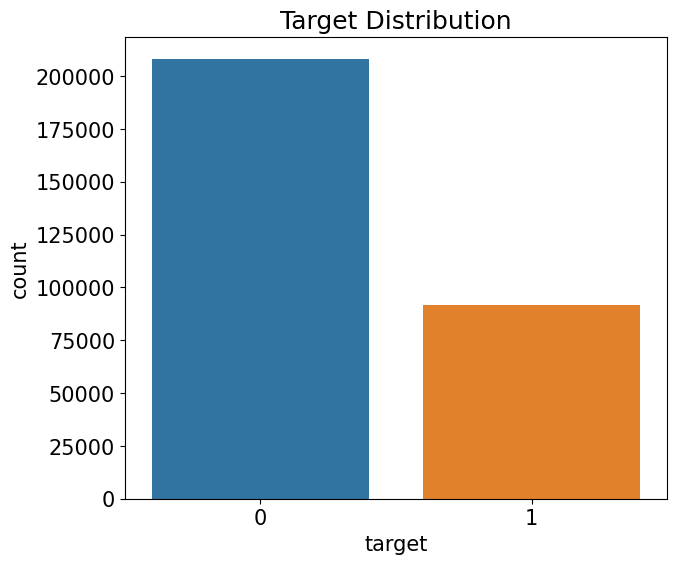

In [46]:
mpl.rc('font', size=15)
plt.figure(figsize=(7,6))

ax = sns.countplot(x='target', data=train)
ax.set_title('Target Distribution')

#### 각 값의 비율 표시

In [50]:
print(ax.patches[0])
print(ax.patches[1])

Rectangle(xy=(-0.4, 0), width=0.8, height=208236, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=91764, angle=0)


- 비율을 표시할 위치 찾기

In [51]:
rectangle = ax.patches[0]
print('사각형 높이:', rectangle.get_height())
print('사각형 너비:', rectangle.get_width())
print('사각형 왼쪽 테두리의 x축 위치:', rectangle.get_x())

사각형 높이: 208236.0
사각형 너비: 0.8
사각형 왼쪽 테두리의 x축 위치: -0.4


In [52]:
print('텍스트 위치의 x좌표: ', rectangle.get_x() + rectangle.get_width()/2.0)
print('텍스트 위치의 y좌표: ', rectangle.get_height() + len(train)*0.001)

텍스트 위치의 x좌표:  0.0
텍스트 위치의 y좌표:  208536.0


- 비율을 표시해주는 코드 함수

In [54]:
def write_percent(ax, total_size):
    '''도형 객체를 순회하며 막대 상단에 타깃값 비율 표시'''
    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()
        percent = height/total_size*100

        ax.text(x=left_coord + width/2.0,
                y=height + total_size*0.001,
                s=f'{percent:1.1f}%',
                ha='center')

Text(0.5, 1.0, 'Target Distribution')

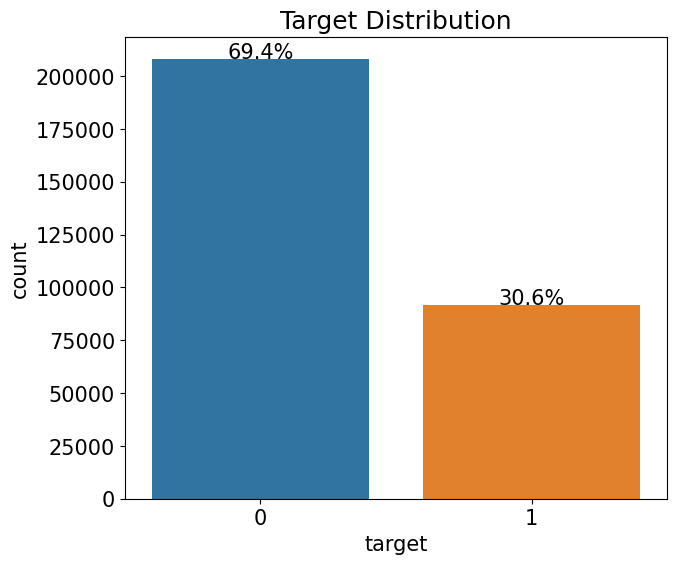

In [55]:
plt.figure(figsize=(7,6))

ax = sns.countplot(x='target',data=train)
write_percent(ax, len(train))
ax.set_title('Target Distribution')

#### 이진 피처 분포
- 범주형 피처의 타깃값 분포를 고윳값별로 구분해 그리기
- bin_0 ~ bin_4 피처의 그래프 그리기

**subplots를 사용하여 여러 그래프 그리기**

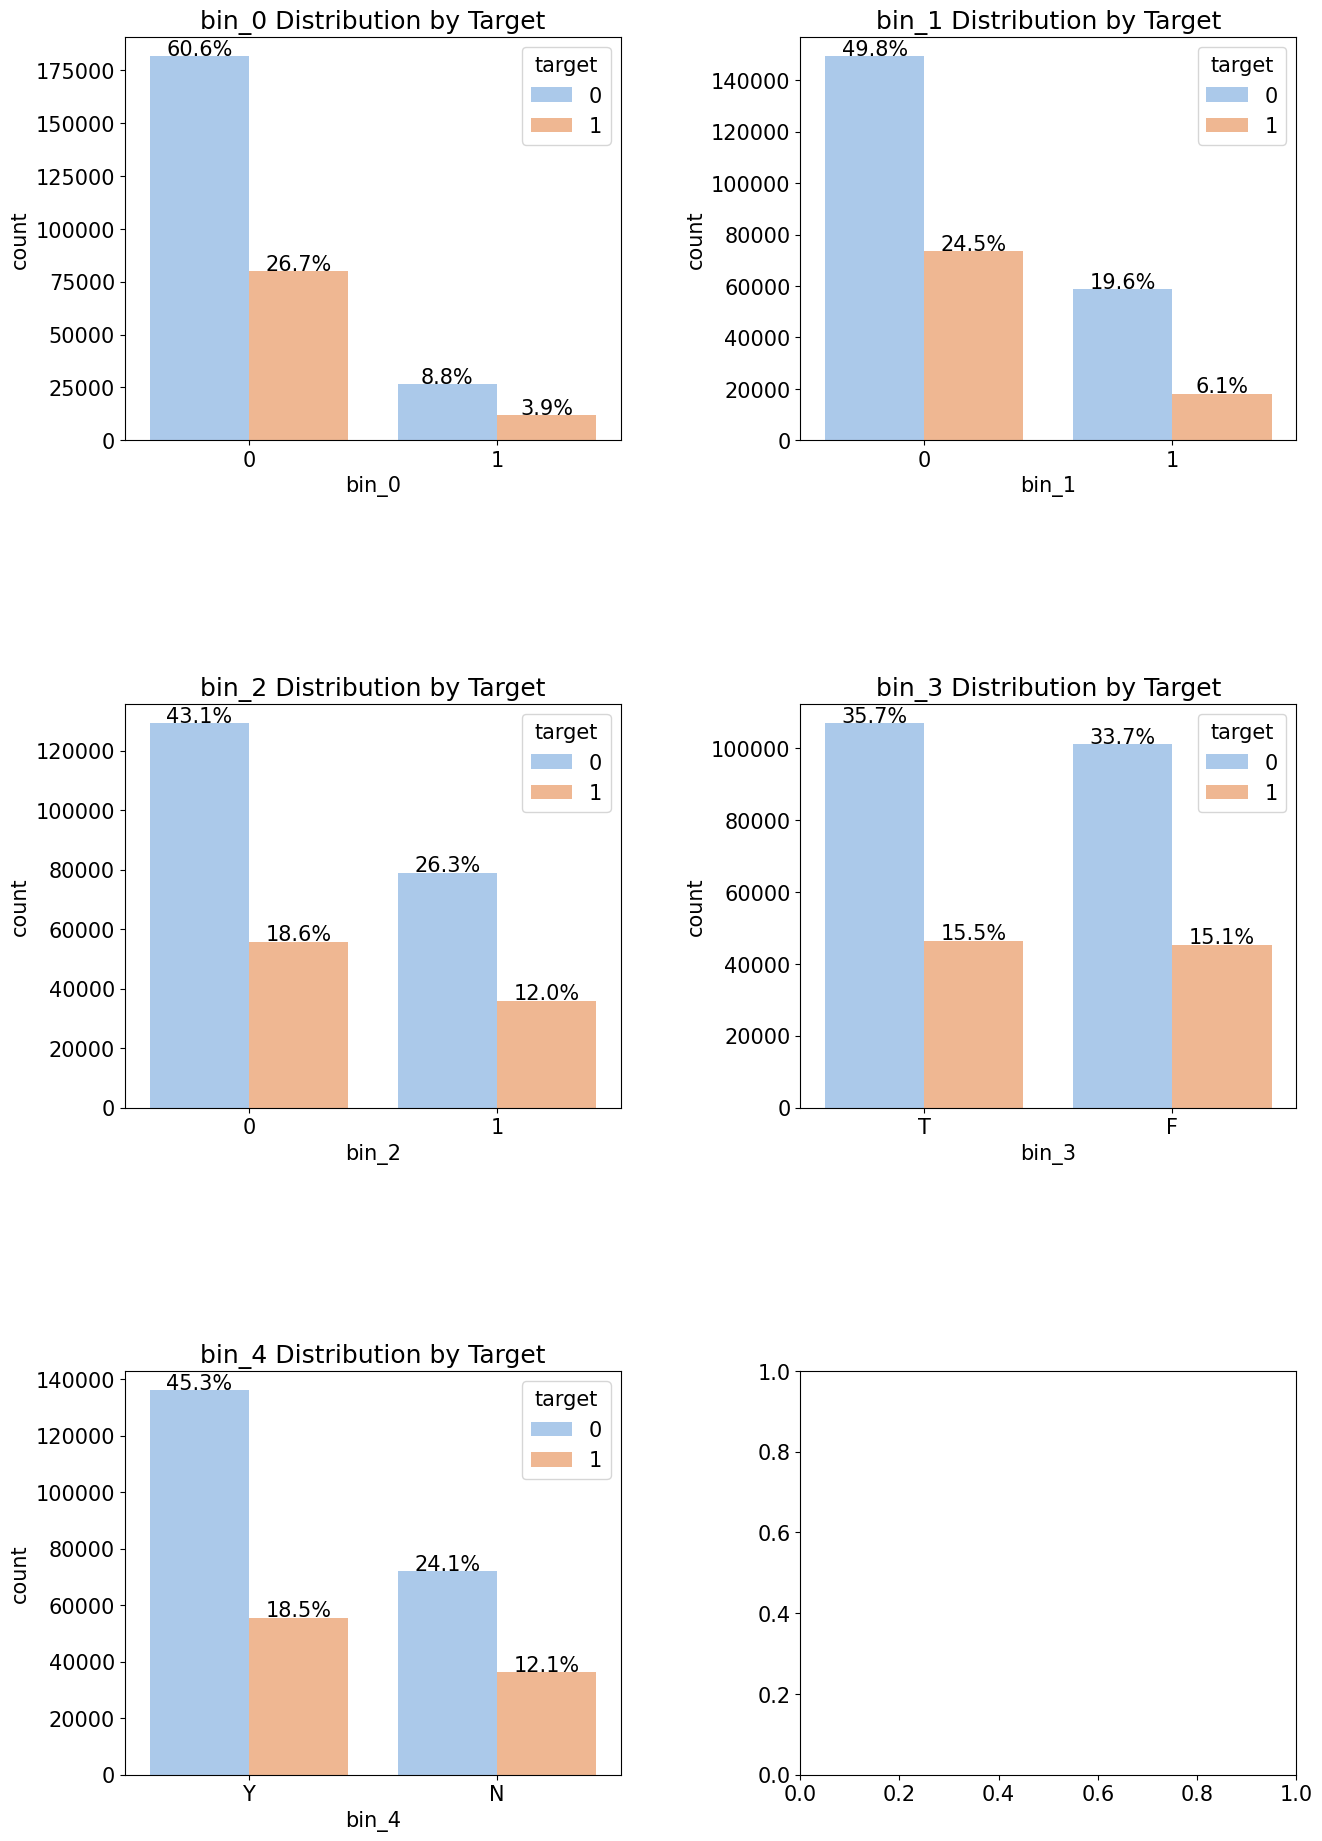

In [75]:
figure, axes = plt.subplots(nrows = 3, ncols=2)
plt.tight_layout()
figure.set_size_inches(14,21)
count=0

for row in range(3):
    for col in range(2):
        column_name = 'bin_' + str(count)
        if column_name == 'bin_5':
            break

        ax = sns.countplot(data=train, x=column_name, hue='target', palette='pastel',ax = axes[row, col])
        write_percent(ax, len(train))
        ax.set_title('{0} Distribution by Target'.format(column_name))
        
        count += 1

**GridSpec을 이용하여 그래프 그리기**
- 여러 그래프를 격자 형태로 배치

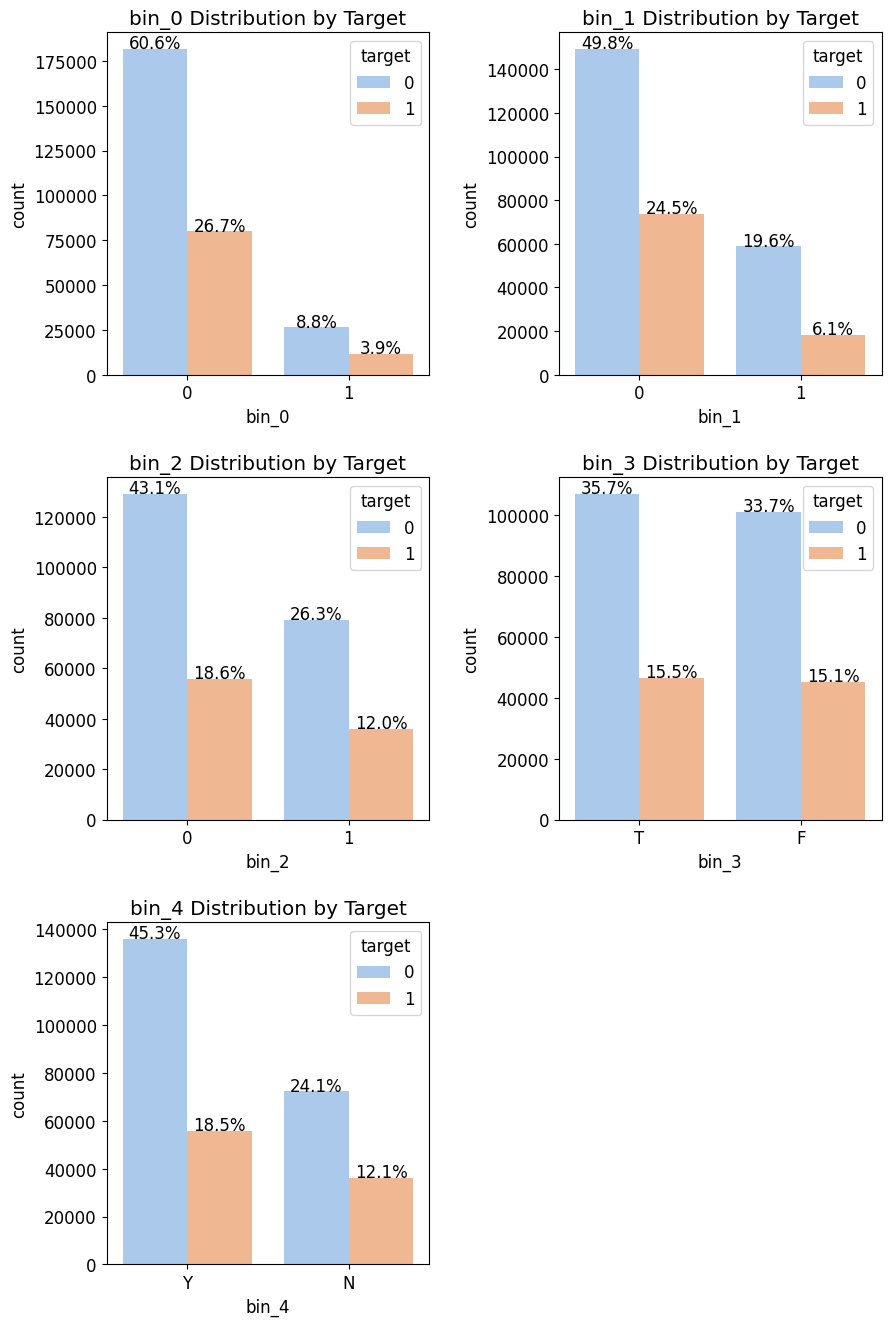

In [82]:
import matplotlib.gridspec as gridspec

# 3행 2열 틀(Figure) 준비
mpl.rc('font', size=12)
grid = gridspec.GridSpec(3,2)
plt.figure(figsize=(10,16))

# 서브플롯 간 좌우/상하 여백 설정
plt.subplots_adjust(wspace=0.4, hspace=0.3)

# 서브플롯 그리기
bin_features = ['bin_0','bin_1','bin_2','bin_3','bin_4']

for idx, feature in enumerate(bin_features):
    ax = plt.subplot(grid[idx])

    sns.countplot(data=train, x=feature, hue='target', palette='pastel', ax=ax)
    write_percent(ax, len(train))
    ax.set_title('{0} Distribution by Target'.format(feature))

- 각 피쳐별로 타깃값 0,1의 분포가 대체로 7:3으로 특정 타깃값에 치우치지 않음

#### 명목형 피처 분포
- 명목형 피처 분포와 명목형 피처별 타깃값 1의 비율 확인

In [83]:
resumetable(train)

데이터셋 형상: (300000, 24)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


- nom_5 ~ nom_9 데이터의 경우 고유값이 많고 데이터 값의 의미를 알 수 없는 문자열로 되어있음 => nom_0 ~ nom_4 만 그래프로 그리기

### 교차분석표 -> 포인트 플롯 -> 피처 분포도 및  포인트플롯 만들기 순서로 그래프 그리기

#### 1. 교차분석표 생성 함수 만들기
- 교차표(cross-tabulation), 교차분석표 : 범주형 데이터 2개를 비교 분석하는 데 사용됨. 각 범주형 데이터의 빈도나 통계량을 행과 열로 결합한 표     
=> 명목형 피처별 타깃값 1 비율 구하기
- crosstab() 함수를 이용하여 교차분석표 만들기

In [84]:
pd.crosstab(train['nom_0'], train['target'])

target,0,1
nom_0,,
Blue,72914,23252
Green,85682,41659
Red,49640,26853


- normalize 파라미터를 이용하여 정규화. 'index' 전달 시, 인덱스를 기준으로 정규화

In [90]:
# normalize 파라미터에 index를 전달하여 각 행별로, 즉 고윳값별로 비율 구하기
crosstab = pd.crosstab(train['nom_0'],train['target'],normalize='index') * 100
crosstab

target,0,1
nom_0,,
Blue,75.820976,24.179024
Green,67.285478,32.714522
Red,64.894827,35.105173


In [92]:
#  현재 인덱스인 피처 이름을 열로 바꿔줘야 함(피처가 열로 설정되어야 그래프를 그리기가 편해지므로)
crosstab = crosstab.reset_index()
crosstab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


**교차분석표를 만드는 함수**

In [108]:
def get_crosstab(df, feature):
    crosstab = pd.crosstab(df[feature], df['target'], normalize='index')*100
    crosstab = crosstab.reset_index()
    return crosstab

In [109]:
crosstab = get_crosstab(train, 'nom_0')
crosstab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


In [110]:
# 타깃값 1 비율 가져오기
crosstab[1]

0    24.179024
1    32.714522
2    35.105173
Name: 1, dtype: float64

#### 2. 포인트플롯 생성 함수 만들기
- 이미 카운트플롯이 그려진 축에 포인트플롯을 **중복**으로 그려줌

**파라미터**
- ax : 포인트플롯을 그릴 축
- feature : 포인트플롯으로 그릴 피처
- crosstab : 교차분석표

#### 카운트플롯에 포인트플롯 그리기

Text(0, 0.5, 'Target 1 Ratio(%)')

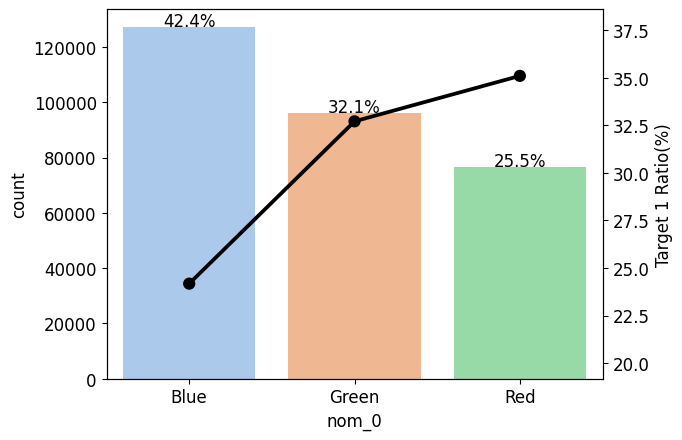

In [112]:
ax = sns.countplot(data=train, x='nom_0', palette='pastel')
write_percent(ax, len(train))

ax2 = ax.twinx()
ax2 = sns.pointplot(data=crosstab, x='nom_0',y=1, order=crosstab['nom_0'].values, color='black')
ax2.set_ylim(crosstab[1].min()-5, crosstab[1].max()*1.1)
ax2.set_ylabel('Target 1 Ratio(%)')

#### 포인트플롯 생성 함수 정의

In [113]:
def plot_pointplot(ax, feature, crosstab):
    # x축은 공유하고 y축은 공유하지 않는 새로운 축 생성
    ax2 = ax.twinx()

    # 새로운 축에 포인트플롯 그리기
    ax2 = sns.pointplot(data=crosstab, x=feature, order=crosstab[feature].values, color='black')

    # y축 범위 설정
    ax2.set_ylim(crosstab[1].min()-5, crosstab[1].max()*1.1)
    ax2.set_ylabel('Target 1 Ratio(%)')

### 3. 피처 분포도 및 피처별 타깃값 1의 비율 포인트플롯 생성 함수 만들기
- get_crosstab()과 plot_pointplot() 함수 이용
- nom_0 ~ nom_4 까지 그래프 그리기

In [118]:
def plot_cat_dist_with_true_ratio(df, features, num_rows, num_cols, size=(15,20)):

    grid = gridspec.GridSpec(num_rows,num_cols)
    plt.figure(figsize=size)

    # 서브플롯 간 좌우/상하 여백 설정
    plt.subplots_adjust(wspace=0.45, hspace=0.3)

    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        crosstab = get_crosstab(df, feature)

        sns.countplot(data=df, x=feature, order=crosstab[feature].values, color='skyblue', ax=ax)
        
        write_percent(ax, len(df))

        plot_pointplot(ax, feature, crosstab)

        ax.set_title('{0} Distribution'.format(feature))

TypeError: Horizontal orientation requires numeric `x` variable.

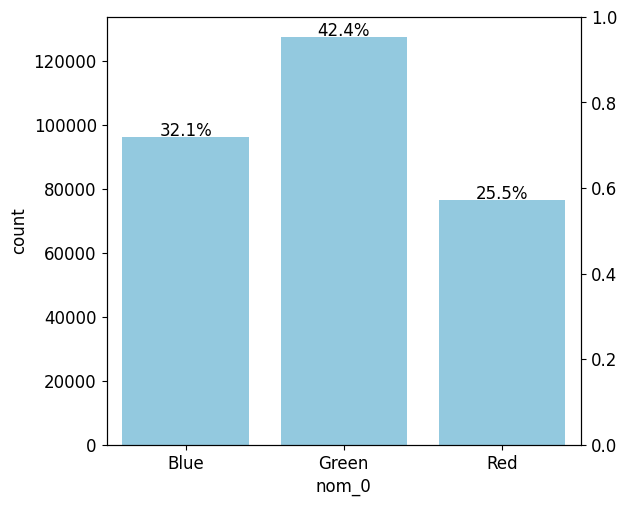

In [120]:
features = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']
plot_cat_dist_with_true_ratio(train, features, 3, 2)